In [39]:
from torch.utils.data import Dataset
import numpy as np
import torch
import os

class LIDCSegmentationDataset(Dataset):
    def __init__(self, dataframe, image_dir, mask_dir, transform=None, patch_size=(256, 256), filter_empty=True):
        self.df = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.patch_size = patch_size
        self.filter_empty = filter_empty

        if self.filter_empty:
            self.df = self.df[self.df.apply(self._has_foreground, axis=1)].reset_index(drop=True)

    def _has_foreground(self, row):
        pid = f"LIDC-IDRI-{str(row.patient_id).zfill(4)}"
        mask_path = os.path.join(self.mask_dir, pid, row.mask_image + ".npy")
        mask = np.load(mask_path)
        return np.sum(mask) > 0

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        pid = f"LIDC-IDRI-{str(row.patient_id).zfill(4)}"
        img_path = os.path.join(self.image_dir, pid, row.original_image + ".npy")
        mask_path = os.path.join(self.mask_dir, pid, row.mask_image + ".npy")

        image = np.load(img_path).astype(np.float32)
        mask = np.load(mask_path).astype(np.uint8)

        # Normalize image
        image = (image - image.min()) / (image.max() - image.min() + 1e-6)

        # Add channel dimension: (1, H, W)
        image = np.expand_dims(image, axis=0)
        mask = np.expand_dims(mask, axis=0)

        # === CROP PATCH AROUND MASK ===
        image, mask = self._crop_patch_around_mask(image, mask)

        if self.transform:
            image, mask = self.transform(image, mask)

        if isinstance(image, np.ndarray):
            image = torch.from_numpy(image).float()
        if isinstance(mask, np.ndarray):
            mask = torch.from_numpy(mask).float()

        return image, mask

    def _crop_patch_around_mask(self, image, mask):
        _, H, W = image.shape
        ph, pw = self.patch_size

        # Get mask bbox
        pos = np.argwhere(mask[0] > 0)
        if pos.size == 0:
            center_y, center_x = H // 2, W // 2  # fallback center
        else:
            y_min, x_min = pos.min(axis=0)
            y_max, x_max = pos.max(axis=0)
            center_y = (y_min + y_max) // 2
            center_x = (x_min + x_max) // 2

        # Crop coordinates
        y1 = max(center_y - ph // 2, 0)
        y2 = min(y1 + ph, H)
        x1 = max(center_x - pw // 2, 0)
        x2 = min(x1 + pw, W)

        # Adjust if patch is clipped
        y1 = y2 - ph if y2 - y1 < ph else y1
        x1 = x2 - pw if x2 - x1 < pw else x1

        return image[:, y1:y2, x1:x2], mask[:, y1:y2, x1:x2]


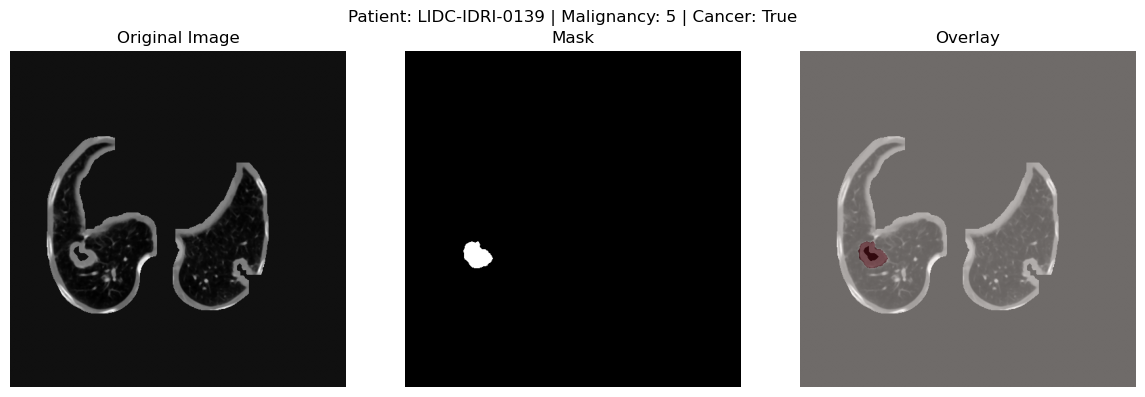

In [164]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# === CONFIG ===
meta_csv = "LIDC-IDRI-Preprocessing-master/data/Meta/meta_info.csv"
image_dir = "LIDC-IDRI-Preprocessing-master/data/Image"
mask_dir = "LIDC-IDRI-Preprocessing-master/data/Mask"

# Load metadata
df = pd.read_csv(meta_csv)

# Filter out ambiguous labels
df = df[df["is_cancer"] != "Ambiguous"]
df = df[df["is_clean"] == False]

# Randomly select a row
example = df.sample(1).iloc[0]
patient_id = f"LIDC-IDRI-{str(example.patient_id).zfill(4)}"
image_path = os.path.join(image_dir, patient_id, example.original_image + ".npy")
mask_path = os.path.join(mask_dir, patient_id, example.mask_image + ".npy")

# Load image and mask
image = np.load(image_path)
mask = np.load(mask_path)

# === PLOT ===
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap="gray")
plt.title("Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(image, cmap="gray")
plt.imshow(mask, cmap="Reds", alpha=0.4)
plt.title("Overlay")
plt.axis("off")

plt.suptitle(f"Patient: {patient_id} | Malignancy: {example.malignancy} | Cancer: {example.is_cancer}")
plt.tight_layout()
plt.show()


In [79]:
import torch
import torch.nn as nn
from monai.losses import DiceLoss

class WeightedDiceBCELoss(nn.Module):
    def __init__(self, pos_weight=1.0, dice_weight=0.5, bce_weight=0.5):
        super().__init__()
        self.dice = DiceLoss(sigmoid=True)
        self.register_buffer('pos_weight', torch.tensor([pos_weight]))
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight

    def forward(self, pred, target):
        # Ensure BCE gets pos_weight on the same device
        bce_loss_fn = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight.to(pred.device))
        bce_loss = bce_loss_fn(pred, target)
        dice_loss = self.dice(pred, target)
        
        total_loss = self.dice_weight * dice_loss + self.bce_weight * bce_loss
        return total_loss



In [80]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from monai.networks.nets import UNet
from monai.metrics import DiceMetric
from monai.transforms import Resize
from monai.utils import set_determinism

# === CONFIG ===
meta_csv = "LIDC-IDRI-Preprocessing-master/data/Meta/meta_info.csv"
image_dir = "LIDC-IDRI-Preprocessing-master/data/Image"
mask_dir = "LIDC-IDRI-Preprocessing-master/data/Mask"
batch_size = 4
max_epochs = 100
lr = 1e-3
resize_shape = (256, 256)
patience = 10  # early stopping patience

set_determinism(seed=42)

# === LOAD CSV AND SPLIT ===
df = pd.read_csv(meta_csv)
df = df[df["is_cancer"] != "Ambiguous"]
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
train_df = train_df[train_df["is_clean"] == False]
val_df = val_df[val_df["is_clean"] == False]

# Count pixels to compute pos_weight
total_pos, total_neg = 0, 0
for _, row in train_df.iterrows():
    pid = f"LIDC-IDRI-{str(row.patient_id).zfill(4)}"
    mask_path = os.path.join(mask_dir, pid, row.mask_image + ".npy")
    mask = np.load(mask_path)
    total_pos += np.sum(mask)
    total_neg += mask.size - np.sum(mask)

pos_weight = total_neg / (total_pos + 1e-6)
print(f"Total positive pixels: {int(total_pos)}")
print(f"Total negative pixels: {int(total_neg)}")
print(f"Recommended pos_weight: {pos_weight:.2f}")

# === MONAI TRANSFORMS ===
def monai_transforms(image, mask):
    image = torch.tensor(image)
    mask = torch.tensor(mask)
    resize = Resize(spatial_size=resize_shape)
    return resize(image), resize(mask)

# === DATASETS & LOADERS ===
train_ds = LIDCSegmentationDataset(train_df, image_dir, mask_dir, transform=monai_transforms)
val_ds = LIDCSegmentationDataset(val_df, image_dir, mask_dir, transform=monai_transforms)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=1)

# === MODEL ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

# === LOSS, OPTIMIZER, SCHEDULER, METRIC ===
loss_fn = WeightedDiceBCELoss(pos_weight=pos_weight, dice_weight=0.5, bce_weight=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2, verbose=True, min_lr=1e-6
)
dice_metric = DiceMetric(include_background=False, reduction="mean")

# === TRAIN LOOP WITH EARLY STOPPING ===
best_dice = 0.0
epochs_no_improve = 0

for epoch in range(max_epochs):
    model.train()
    epoch_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    print(f"[Epoch {epoch+1}] Avg Train Loss: {avg_loss:.4f}")

    # === VALIDATION ===
    model.eval()
    dice_metric.reset()
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = torch.sigmoid(model(val_images))
            val_outputs = (val_outputs > 0.5).float()
            dice_metric(y_pred=val_outputs, y=val_labels)

        val_dice = dice_metric.aggregate().item()
        print(f"[Epoch {epoch+1}] Validation Dice Score: {val_dice:.4f}")

        if val_dice > best_dice:
            best_dice = val_dice
            epochs_no_improve = 0
            torch.save(model.state_dict(), "best_model.pth")
            print(f"✅ Saved new best model at epoch {epoch+1} (Dice: {val_dice:.4f})")
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve} epoch(s).")

        if epochs_no_improve >= patience:
            print(f"🛑 Early stopping triggered at epoch {epoch+1}")
            break
        # Step the scheduler
        scheduler.step(val_dice)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"[Epoch {epoch+1}] Current LR: {current_lr:.6f}")



Total positive pixels: 284405
Total negative pixels: 309569803
Recommended pos_weight: 1088.48
[Epoch 1] Avg Train Loss: 1.0526
[Epoch 1] Validation Dice Score: 0.0272
✅ Saved new best model at epoch 1 (Dice: 0.0272)
[Epoch 1] Current LR: 0.001000
[Epoch 2] Avg Train Loss: 0.8976
[Epoch 2] Validation Dice Score: 0.0610
✅ Saved new best model at epoch 2 (Dice: 0.0610)
[Epoch 2] Current LR: 0.001000
[Epoch 3] Avg Train Loss: 0.7898
[Epoch 3] Validation Dice Score: 0.0587
No improvement for 1 epoch(s).
[Epoch 3] Current LR: 0.001000
[Epoch 4] Avg Train Loss: 0.7303
[Epoch 4] Validation Dice Score: 0.1385
✅ Saved new best model at epoch 4 (Dice: 0.1385)
[Epoch 4] Current LR: 0.001000
[Epoch 5] Avg Train Loss: 0.7191
[Epoch 5] Validation Dice Score: 0.1010
No improvement for 1 epoch(s).
[Epoch 5] Current LR: 0.001000
[Epoch 6] Avg Train Loss: 0.6473
[Epoch 6] Validation Dice Score: 0.0799
No improvement for 2 epoch(s).
[Epoch 6] Current LR: 0.001000
[Epoch 7] Avg Train Loss: 0.6262
[Epoch 7

Classification

In [113]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from skimage.transform import resize
from tqdm import tqdm

# === CONFIG ===
meta_csv = "LIDC-IDRI-Preprocessing-master/data/Meta/meta_info.csv"
image_dir = "LIDC-IDRI-Preprocessing-master/data/Image"
mask_dir = "LIDC-IDRI-Preprocessing-master/data/Mask"
output_dir = "patches"
patch_size = (64, 64)
padding = 8  # Optional padding around nodule

# === Load metadata
df = pd.read_csv(meta_csv)
df = df[df["is_cancer"] != "Ambiguous"]
df = df[df["is_clean"] == False]  # Remove clean slices

Path(f"{output_dir}/benign").mkdir(parents=True, exist_ok=True)
Path(f"{output_dir}/malignant").mkdir(parents=True, exist_ok=True)

patch_id = 0

for _, row in tqdm(df.iterrows(), total=len(df)):
    pid = f"LIDC-IDRI-{str(row.patient_id).zfill(4)}"
    image_path = os.path.join(image_dir, pid, row.original_image + ".npy")
    mask_path = os.path.join(mask_dir, pid, row.mask_image + ".npy")

    if not os.path.exists(image_path) or not os.path.exists(mask_path):
        continue

    image = np.load(image_path)
    mask = np.load(mask_path)
   
    # Skip if mask is empty (just in case)
    if np.sum(mask) == 0:
        continue

    # Find bounding box of mask
    y_indices, x_indices = np.where(mask > 0)
    # Handle both (1, H, W) and (H, W)
    if image.ndim == 3:
        image = image[0]

    height, width = image.shape

    x_min = max(x_indices.min() - padding, 0)
    x_max = min(x_indices.max() + padding, width)
    y_min = max(y_indices.min() - padding, 0)
    y_max = min(y_indices.max() + padding, height)

    patch = image[y_min:y_max, x_min:x_max]

    # Resize patch
    patch_resized = resize(patch, patch_size, mode="reflect", anti_aliasing=True)

    # Save to correct folder
    label = "malignant" if str(row.is_cancer).lower() == "true" else "benign"
    out_path = os.path.join(output_dir, label, f"{row.patient_id:04d}_{row.original_image}.npy")
    np.save(out_path, patch_resized.astype(np.float32))
    patch_id += 1

print(f"✅ Done. Extracted {patch_id} patches.")


100%|██████████| 1473/1473 [00:04<00:00, 364.22it/s]

✅ Done. Extracted 1473 patches.


Dataset Class for Classification

In [99]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class NPYImageFolder(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.classes = ["benign", "malignant"]
        self.filepaths = []
        self.labels = []

        for label_idx, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            for fname in os.listdir(class_path):
                if fname.endswith(".npy"):
                    self.filepaths.append(os.path.join(class_path, fname))
                    self.labels.append(label_idx)

        self.transform = transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img = np.load(self.filepaths[idx]).astype(np.float32)

        # Normalize to [0, 1]
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)

        # Convert to 3 channels
        img = np.stack([img] * 3, axis=0)  # (3, H, W)

        img = torch.tensor(img)

        if self.transform:
            img = self.transform(img)

        label = self.labels[idx]
        return img, label


In [265]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
from torchvision import transforms
import numpy as np

resize_transform = transforms.Compose([
    transforms.Resize((224, 224))
])

dataset = NPYImageFolder("patches", transform=resize_transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

# === Model ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

# === Loss, Optimizer, Scheduler ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

# === Early Stopping Config ===
best_val_acc = 0.0
epochs_no_improve = 0
early_stop_patience = 5
max_epochs = 50

# === Training Loop ===
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_acc = correct_train / total_train
    avg_loss = running_loss / len(train_loader)

    # === Validation ===
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_acc = correct_val / total_val
    scheduler.step(val_acc)

    print(f"[Epoch {epoch+1}] Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

    # === Early Stopping ===
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_classifier.pth")
        print(f"✅ Saved new best model at epoch {epoch+1} (Val Acc: {val_acc:.4f})")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= early_stop_patience:
        print(f"🛑 Early stopping triggered at epoch {epoch+1}")
        break


/opt/anaconda3/envs/brat/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Epoch 1] Loss: 0.4843, Train Acc: 0.7971, Val Acc: 0.8373, LR: 0.001000
✅ Saved new best model at epoch 1 (Val Acc: 0.8373)
[Epoch 2] Loss: 0.3325, Train Acc: 0.8616, Val Acc: 0.6271, LR: 0.001000
No improvement for 1 epoch(s).
[Epoch 3] Loss: 0.3083, Train Acc: 0.8659, Val Acc: 0.8508, LR: 0.001000
✅ Saved new best model at epoch 3 (Val Acc: 0.8508)
[Epoch 4] Loss: 0.2828, Train Acc: 0.8930, Val Acc: 0.8847, LR: 0.001000
✅ Saved new best model at epoch 4 (Val Acc: 0.8847)
[Epoch 5] Loss: 0.2470, Train Acc: 0.9007, Val Acc: 0.8305, LR: 0.001000
No improvement for 1 epoch(s).
[Epoch 6] Loss: 0.2168, Train Acc: 0.9126, Val Acc: 0.8542, LR: 0.001000
No improvement for 2 epoch(s).
[Epoch 7] Loss: 0.1787, Train Acc: 0.9321, Val Acc: 0.8576, LR: 0.001000
No improvement for 3 epoch(s).
[Epoch 8] Loss: 0.1387, Train Acc: 0.9491, Val Acc: 0.8712, LR: 0.000500
No improvement for 4 epoch(s).
[Epoch 9] Loss: 0.0798, Train Acc: 0.9720, Val Acc: 0.9017, LR: 0.000500
✅ Saved new best model at epoch 

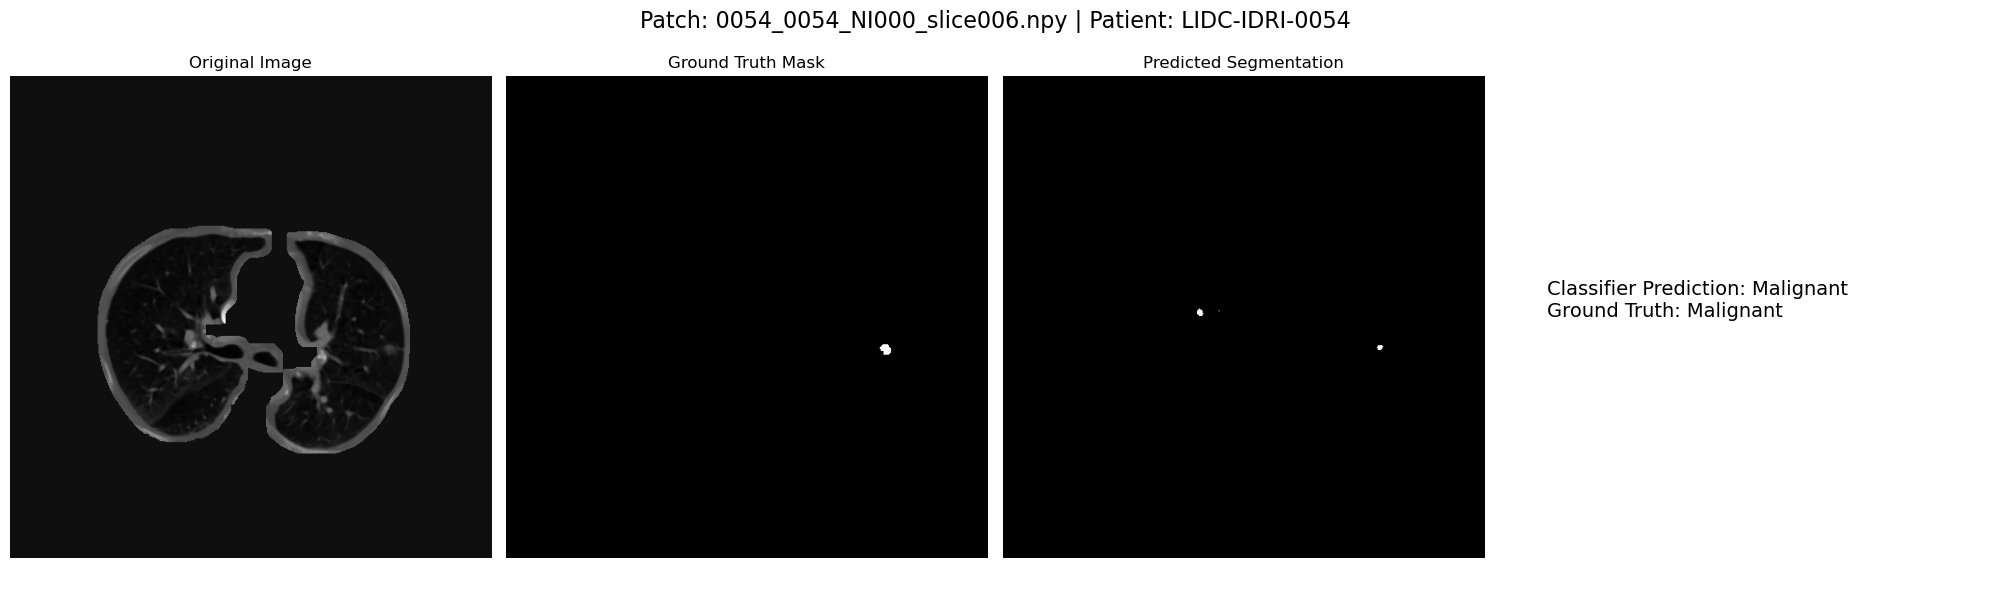

In [317]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from monai.networks.nets import UNet
from torchvision import models, transforms

# === CONFIG ===
patch_dir = "patches"
image_dir = "LIDC-IDRI-Preprocessing-master/data/Image"
mask_dir = "LIDC-IDRI-Preprocessing-master/data/Mask"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resize_shape = (256, 256)
patch_size = (64, 64)

# === LOAD MODELS ===

# Load segmentation model (UNet)
seg_model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)
seg_model.load_state_dict(torch.load("best_model.pth", map_location=device))
seg_model.eval()

# Load classifier (ResNet18)
cls_model = models.resnet18(pretrained=False)
cls_model.fc = nn.Linear(cls_model.fc.in_features, 2)
cls_model.load_state_dict(torch.load("best_classifier.pth", map_location=device))
cls_model.eval().to(device)

# === CLASSIFIER TRANSFORM ===
patch_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(patch_size),
    transforms.Normalize([0.5], [0.5]),
])

# === RANDOM SAMPLE ===
label = random.choice(["benign", "malignant"])
patch_files = os.listdir(os.path.join(patch_dir, label))
patch_file = random.choice(patch_files)

# Parse file name
filename_parts = patch_file.replace(".npy", "").split("_")
patient_id = filename_parts[0]
image_name = "_".join(filename_parts[1:])
pid_full = f"LIDC-IDRI-{patient_id}"

# === Load data ===
image_path = os.path.join(image_dir, pid_full, image_name + ".npy")
mask_path = os.path.join(mask_dir, pid_full, image_name.replace("NI", "MA") + ".npy")
patch_path = os.path.join(patch_dir, label, patch_file)

original_image = np.load(image_path).astype(np.float32)
mask = np.load(mask_path).astype(np.uint8)
patch = np.load(patch_path).astype(np.float32)

# === SEGMENTATION PREDICTION ===
input_img = torch.tensor(original_image).unsqueeze(0).unsqueeze(0).to(device)
with torch.no_grad():
    pred_seg = torch.sigmoid(seg_model(input_img))
    pred_seg = (pred_seg > 0.5).float().squeeze().cpu().numpy()

# === CLASSIFICATION PREDICTION ===
patch_tensor = patch_transform(patch).unsqueeze(0).to(device)
if patch_tensor.shape[1] == 1:
    patch_tensor = patch_tensor.repeat(1, 3, 1, 1)

with torch.no_grad():
    probs = torch.softmax(cls_model(patch_tensor), dim=1)
    cls_pred = torch.argmax(probs).item()

cls_label = "Malignant" if cls_pred == 1 else "Benign"
gt_label = "Malignant" if label == "malignant" else "Benign"

# === VISUALIZATION ===
plt.figure(figsize=(20, 6))  # Increased figure size

plt.subplot(1, 4, 1)
plt.imshow(original_image, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(mask, cmap="gray")
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(pred_seg, cmap="gray")
plt.title("Predicted Segmentation")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.text(0.1, 0.5,
         f"Classifier Prediction: {cls_label}\nGround Truth: {gt_label}",
         fontsize=14)
plt.axis("off")

plt.suptitle(f"Patch: {patch_file} | Patient: {pid_full}", fontsize=16)
plt.tight_layout()
plt.show()
